# Breast Ultrasound (BUSI) — Two-Stage AI Pipeline  
## 1) U-Net Segmentation (mask prediction) + 2) 3-Class Classification (normal / benign / malignant)

This notebook implements a **two-stage pipeline**:

1. **U-Net** predicts a **binary lesion mask** from an ultrasound image.  
2. A **mask-aware classifier** predicts **normal / benign / malignant** using a **2-channel input**:
   - channel 1: ultrasound image  
   - channel 2: predicted mask (from U-Net)


##  Setup

- Download dataset from Kaggle (BUSI): https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset  
- or if your own data
  - Ensure folder structure is like:

```
DATASET_ROOT/
  benign/
    *.png
    *_mask.png
  malignant/
    *.png
    *_mask.png
  normal/
    *.png
```



In [ ]:
# (Optional) Install dependencies if needed
# !pip install -r requirements.txt

In [1]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

print("GPU ready")

2026-02-26 22:37:17.579306: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-26 22:37:17.616801: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-26 22:37:18.510394: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


GPU ready


In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras import layers

print("TensorFlow:", tf.__version__)


TensorFlow: 2.20.0


## 1) Configuration

In [ ]:
DATASET_ROOT = r"/home/gokul-o-s/Desktop/Uni_Proj/Breast_Cancer_Detection/Dataset_BUSI_with_GT" 
IMG_SIZE = 256

# Model output paths
UNET_PATH = "unet_model.keras"
CLF_PATH  = "classifier_model.keras"

# Class mapping
CLASS_MAP = {"normal": 0, "benign": 1, "malignant": 2}
IDX2CLASS = {v: k for k, v in CLASS_MAP.items()}

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)


## 2) Data loading (3 classes + masks)

In [ ]:
def read_gray(path: str, img_size: int) -> np.ndarray | None:
    """Read grayscale image, resize, normalize to [0,1]."""
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    img = cv2.resize(img, (img_size, img_size))
    img = img.astype(np.float32) / 255.0
    return img

def make_empty_mask(img_size: int) -> np.ndarray:
    return np.zeros((img_size, img_size), dtype=np.float32)

def load_busi_dataset(root_dir: str, img_size: int = 256):
    """
    Loads BUSI dataset from class folders.
    Returns:
      X: (N,H,W,1) float32
      Y_mask: (N,H,W,1) float32 binary {0,1}  (empty for normals)
      y_class: (N,) int labels 0..2
      has_mask: (N,) bool  True if *_mask.png exists
    """
    X, Y_mask, y_class, has_mask = [], [], [], []

    for cls_name, cls_id in CLASS_MAP.items():
        cls_dir = os.path.join(root_dir, cls_name)
        if not os.path.isdir(cls_dir):
            print(f"[WARN] Missing folder: {cls_dir}")
            continue

        img_paths = sorted(glob(os.path.join(cls_dir, "*.png")))
        img_paths = [p for p in img_paths if not p.endswith("_mask.png")]

        for img_path in img_paths:
            img = read_gray(img_path, img_size)
            if img is None:
                continue

            mask_path = img_path.replace(".png", "_mask.png")
            if os.path.exists(mask_path):
                mask = read_gray(mask_path, img_size)
                if mask is None:
                    continue
                mask = (mask > 0.5).astype(np.float32)
                mask_exists = True
            else:
                mask = make_empty_mask(img_size)
                mask_exists = False

            X.append(img[..., None])
            Y_mask.append(mask[..., None])
            y_class.append(cls_id)
            has_mask.append(mask_exists)

    X = np.array(X, dtype=np.float32)
    Y_mask = np.array(Y_mask, dtype=np.float32)
    y_class = np.array(y_class, dtype=np.int32)
    has_mask = np.array(has_mask, dtype=bool)

    return X, Y_mask, y_class, has_mask


In [13]:
# Load dataset
X_all, Y_mask_all, y_all, has_mask_all = load_busi_dataset(DATASET_ROOT, IMG_SIZE)

print("X_all:", X_all.shape)
print("Y_mask_all:", Y_mask_all.shape)
print("y_all:", y_all.shape, "classes:", {k:int(np.sum(y_all==v)) for k,v in CLASS_MAP.items()})
print("has_mask_all:", has_mask_all.shape, "with masks:", int(has_mask_all.sum()))


X_all: (798, 256, 256, 1)
Y_mask_all: (798, 256, 256, 1)
y_all: (798,) classes: {'normal': 133, 'benign': 454, 'malignant': 211}
has_mask_all: (798,) with masks: 780


## 3) Quick visualization

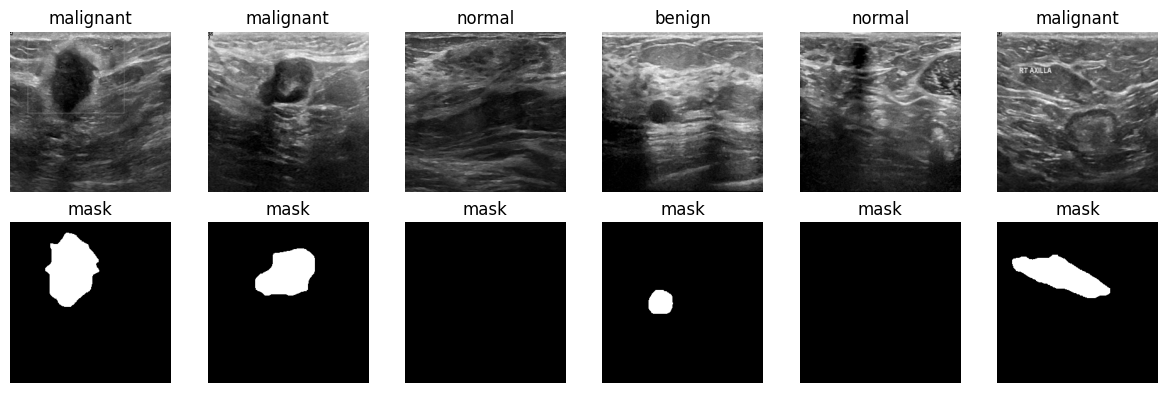

In [14]:
def show_samples(X, Y_mask, y, n=6):
    idxs = np.random.choice(len(X), size=min(n, len(X)), replace=False)
    plt.figure(figsize=(12, 4))
    for i, idx in enumerate(idxs):
        img = X[idx, ..., 0]
        mask = Y_mask[idx, ..., 0]
        label = IDX2CLASS[int(y[idx])]

        plt.subplot(2, len(idxs), i+1)
        plt.imshow(img, cmap="gray")
        plt.title(label)
        plt.axis("off")

        plt.subplot(2, len(idxs), len(idxs)+i+1)
        plt.imshow(mask, cmap="gray")
        plt.title("mask")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_samples(X_all, Y_mask_all, y_all, n=6)


## 4) U-Net for lesion segmentation

In [ ]:
def conv_block(x, num_filters):
    x = Conv2D(num_filters, (3,3), activation="relu", padding="same", kernel_initializer="he_normal")(x)
    x = Conv2D(num_filters, (3,3), activation="relu", padding="same", kernel_initializer="he_normal")(x)
    return x

def encoder_block(x, num_filters):
    s = conv_block(x, num_filters)
    p = MaxPooling2D((2,2))(s)
    return s, p

def decoder_block(x, skip, num_filters):
    x = Conv2DTranspose(num_filters, (2,2), strides=2, padding="same")(x)
    x = concatenate([x, skip])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape=(256,256,1)):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, (1,1), padding="same", activation="sigmoid")(d4)

    return Model(inputs, outputs, name="U-Net")

### 4.1 Dice metric + BCE+Dice loss

In [16]:
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_pred = tf.clip_by_value(y_pred, 0.0, 1.0)

    intersection = tf.reduce_sum(y_true * y_pred, axis=[1,2,3])
    union = tf.reduce_sum(y_true, axis=[1,2,3]) + tf.reduce_sum(y_pred, axis=[1,2,3])
    return tf.reduce_mean((2.0 * intersection + smooth) / (union + smooth))

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    return bce + (1.0 - dice_coef(y_true, y_pred))


### 4.2 Train U-Net (only samples that have real masks)

In [17]:
# Filter to masked samples for segmentation training
X_seg = X_all[has_mask_all]
Y_seg = Y_mask_all[has_mask_all]

X_train, X_val, Y_train, Y_val = train_test_split(
    X_seg, Y_seg,
    test_size=0.2,
    random_state=SEED
)

print("Seg train:", X_train.shape, Y_train.shape)
print("Seg val:  ", X_val.shape, Y_val.shape)


Seg train: (624, 256, 256, 1) (624, 256, 256, 1)
Seg val:   (156, 256, 256, 1) (156, 256, 256, 1)


In [ ]:
unet = build_unet((IMG_SIZE, IMG_SIZE, 1))
unet.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=bce_dice_loss,
    metrics=[dice_coef]
)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(UNET_PATH, save_best_only=True, monitor="val_dice_coef", mode="max"),
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor="val_dice_coef", mode="max"), #Used to prevent overfitting and save time by stopping training when validation performance stops improving.
    tf.keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.5, monitor="val_dice_coef", mode="max"),
]

history_unet = unet.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=60,
    batch_size=8,
    callbacks=callbacks
)


Epoch 1/60


2026-02-26 22:38:43.539510: I external/local_xla/xla/service/service.cc:163] XLA service 0x7edf7800a1e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-02-26 22:38:43.539538: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2026-02-26 22:38:43.638484: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-02-26 22:38:44.339319: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91900
2026-02-26 22:38:45.352902: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.30GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2026-02-26 22:38:45.71183

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - dice_coef: 0.1047 - loss: 1.2956

2026-02-26 22:39:44.253593: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-26 22:39:44.398547: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


78/78 ━━━━━━━━━━━━━━━━━━━━ 68s 474ms/step - dice_coef: 0.1021 - loss: 1.2380 - val_dice_coef: 0.1085 - val_loss: 1.2160 - learning_rate: 1.0000e-04
Epoch 2/60
78/78 ━━━━━━━━━━━━━━━━━━━━ 24s 313ms/step - dice_coef: 0.1389 - loss: 1.1500 - val_dice_coef: 0.2218 - val_loss: 1.0002 - learning_rate: 1.0000e-04
Epoch 3/60
78/78 ━━━━━━━━━━━━━━━━━━━━ 25s 315ms/step - dice_coef: 0.2560 - loss: 0.9877 - val_dice_coef: 0.2889 - val_loss: 0.9488 - learning_rate: 1.0000e-04
Epoch 4/60
78/78 ━━━━━━━━━━━━━━━━━━━━ 25s 316ms/step - dice_coef: 0.3160 - loss: 0.9083 - val_dice_coef: 0.3527 - val_loss: 0.8426 - learning_rate: 1.0000e-04
Epoch 5/60
78/78 ━━━━━━━━━━━━━━━━━━━━ 25s 317ms/step - dice_coef: 0.3640 - loss: 0.8470 - val_dice_coef: 0.3982 - val_loss: 0.7747 - learning_rate: 1.0000e-04
Epoch 6/60
78/78 ━━━━━━━━━━━━━━━━━━━━ 25s 316ms/step - dice_coef: 0.4253 - loss: 0.7629 - val_dice_coef: 0.4344 - val_loss: 0.7390 - learning_rate: 1.0000e-04
Epoch 7/60
78/78 ━━━━━━━━━━━━━━━━━━━━ 25s 317ms/step - di

### 4.3 Visualize segmentation predictions

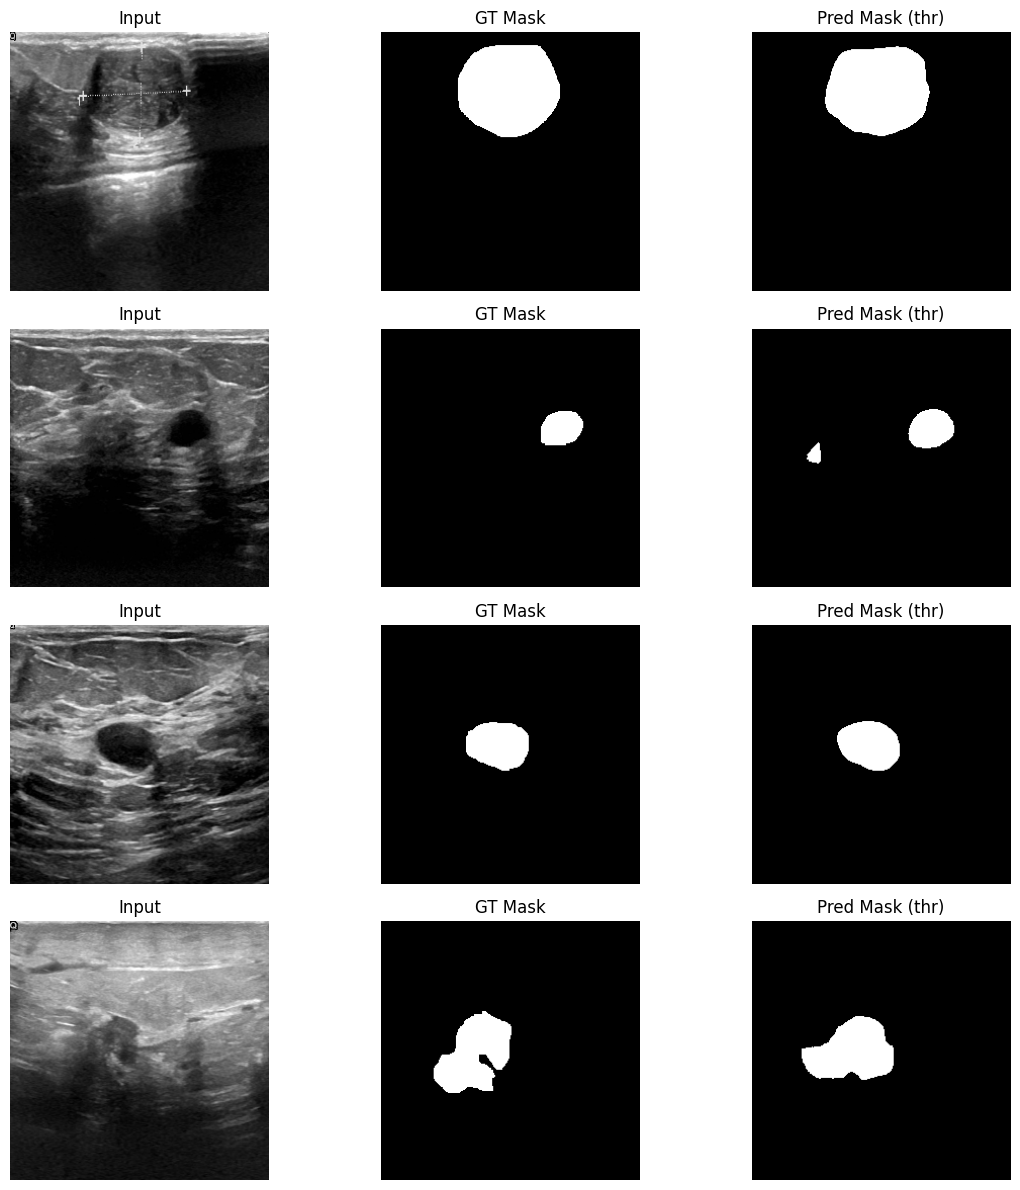

In [28]:
def predict_and_show_seg(model, X, Y, n=4, threshold=0.5):
    idxs = np.random.choice(len(X), size=min(n, len(X)), replace=False)
    plt.figure(figsize=(12, 3*n))
    for i, idx in enumerate(idxs):
        img = X[idx:idx+1]
        gt  = Y[idx, ..., 0]
        pred = model.predict(img, verbose=0)[0, ..., 0]
        pred_bin = (pred > threshold).astype(np.float32)

        plt.subplot(n, 3, i*3 + 1)
        plt.imshow(img[0, ..., 0], cmap="gray")
        plt.title("Input")
        plt.axis("off")

        plt.subplot(n, 3, i*3 + 2)
        plt.imshow(gt, cmap="gray")
        plt.title("GT Mask")
        plt.axis("off")

        plt.subplot(n, 3, i*3 + 3)
        plt.imshow(pred_bin, cmap="gray")
        plt.title("Pred Mask (thr)")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

predict_and_show_seg(unet, X_val, Y_val, n=4)


## 5) Mask-aware 3-class classifier (normal/benign/malignant)

### Classifier input design

We build a **2-channel tensor**:
- Channel 1: ultrasound image
- Channel 2: predicted mask (from trained U-Net)

This is simple, effective, and easy to explain to recruiters.


In [29]:
def build_mask_classifier(input_shape=(256,256,2), num_classes=3):
    inp = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, 3, padding="same", activation="relu")(inp)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(256, 3, padding="same", activation="relu")(x)
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dropout(0.3)(x)
    out = layers.Dense(num_classes, activation="softmax")(x)

    return Model(inp, out, name="MaskAwareClassifier")


### 5.1 Split data for classification (all classes)

In [30]:
Xc_train, Xc_val, yc_train, yc_val = train_test_split(
    X_all, y_all,
    test_size=0.2,
    random_state=SEED,
    stratify=y_all
)

print("Cls train:", Xc_train.shape, yc_train.shape)
print("Cls val:  ", Xc_val.shape, yc_val.shape)


Cls train: (638, 256, 256, 1) (638,)
Cls val:   (160, 256, 256, 1) (160,)


### 5.2 Generate predicted masks *after* splitting (avoid leakage)

In [31]:
# Load best U-Net weights saved by checkpoint (or use current unet in memory)
unet_loaded = tf.keras.models.load_model(
    UNET_PATH,
    custom_objects={"bce_dice_loss": bce_dice_loss, "dice_coef": dice_coef}
)

pred_train = unet_loaded.predict(Xc_train, batch_size=8, verbose=1)
pred_val   = unet_loaded.predict(Xc_val, batch_size=8, verbose=1)

# Threshold predicted masks (you can also pass probabilities instead of binaries)
pred_train_bin = (pred_train > 0.5).astype(np.float32)
pred_val_bin   = (pred_val > 0.5).astype(np.float32)

# Build 2-channel inputs: [image, predicted_mask]
X2_train = np.concatenate([Xc_train, pred_train_bin], axis=-1)  # (N,H,W,2)
X2_val   = np.concatenate([Xc_val, pred_val_bin], axis=-1)

print("X2_train:", X2_train.shape)
print("X2_val:  ", X2_val.shape)


80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step
X2_train: (638, 256, 256, 2)
X2_val:   (160, 256, 256, 2)


### 5.3 Train the classifier

In [32]:
clf = build_mask_classifier((IMG_SIZE, IMG_SIZE, 2), num_classes=3)
clf.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks_clf = [
    tf.keras.callbacks.ModelCheckpoint(CLF_PATH, save_best_only=True, monitor="val_accuracy", mode="max"),
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor="val_accuracy"),
    tf.keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.5, monitor="val_accuracy", mode="max"),
]

history_clf = clf.fit(
    X2_train, yc_train,
    validation_data=(X2_val, yc_val),
    epochs=60,
    batch_size=16,
    callbacks=callbacks_clf
)


Epoch 1/60
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.5643 - loss: 0.9824 - val_accuracy: 0.5688 - val_loss: 0.9302 - learning_rate: 1.0000e-04
Epoch 2/60
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5705 - loss: 0.8990 - val_accuracy: 0.6062 - val_loss: 0.8072 - learning_rate: 1.0000e-04
Epoch 3/60
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5752 - loss: 0.8122 - val_accuracy: 0.6125 - val_loss: 0.7229 - learning_rate: 1.0000e-04
Epoch 4/60
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5909 - loss: 0.7654 - val_accuracy: 0.6062 - val_loss: 0.6804 - learning_rate: 1.0000e-04
Epoch 5/60
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.6803 - loss: 0.7458 - val_accuracy: 0.7500 - val_loss: 0.6415 - learning_rate: 1.0000e-04
Epoch 6/60
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7069 - loss: 0.7452 - val_accuracy: 0.7500 - val_loss: 0.6350 - learning_rate: 1.0000e-04
Epoch 7/60
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7398 

### 5.4 Evaluate classification

In [33]:
clf_loaded = tf.keras.models.load_model(CLF_PATH)

probs = clf_loaded.predict(X2_val, verbose=0)
preds = np.argmax(probs, axis=1)

print("Classification report:\n")
print(classification_report(yc_val, preds, target_names=[IDX2CLASS[i] for i in range(3)]))

print("Confusion matrix:\n")
print(confusion_matrix(yc_val, preds))


Classification report:

              precision    recall  f1-score   support

      normal       0.93      1.00      0.96        27
      benign       0.77      0.92      0.84        91
   malignant       0.77      0.40      0.53        42

    accuracy                           0.80       160
   macro avg       0.82      0.78      0.78       160
weighted avg       0.80      0.80      0.78       160

Confusion matrix:

[[27  0  0]
 [ 2 84  5]
 [ 0 25 17]]


## 6) End-to-end inference: image → predicted mask + class

In [34]:
LABELS = [IDX2CLASS[i] for i in range(3)]

def preprocess_single(path, img_size=256):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(path)
    img = cv2.resize(img, (img_size, img_size)).astype(np.float32) / 255.0
    return img[None, ..., None]  # (1,H,W,1)

def overlay_mask(gray_img_2d, mask_2d, alpha=0.35):
    """Create a simple overlay visualization (mask brightening)."""
    gray = (gray_img_2d * 255).astype(np.uint8)
    mask = (mask_2d > 0.5).astype(np.uint8) * 255
    # Convert to BGR for overlay-like effect (still viewable in matplotlib)
    gray_bgr = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
    mask_bgr = cv2.applyColorMap(mask, cv2.COLORMAP_JET)
    out = cv2.addWeighted(gray_bgr, 1.0, mask_bgr, alpha, 0)
    return out

def predict_mask_and_class(image_path, unet_model, clf_model):
    x = preprocess_single(image_path, IMG_SIZE)

    pred_mask = unet_model.predict(x, verbose=0)[0, :, :, 0]  # (H,W)
    pred_mask_bin = (pred_mask > 0.5).astype(np.float32)

    x2 = np.concatenate([x[0], pred_mask_bin[..., None]], axis=-1)[None, ...]  # (1,H,W,2)
    probs = clf_model.predict(x2, verbose=0)[0]
    cls_id = int(np.argmax(probs))

    return pred_mask, cls_id, probs


Using temp sample: _temp_sample.png


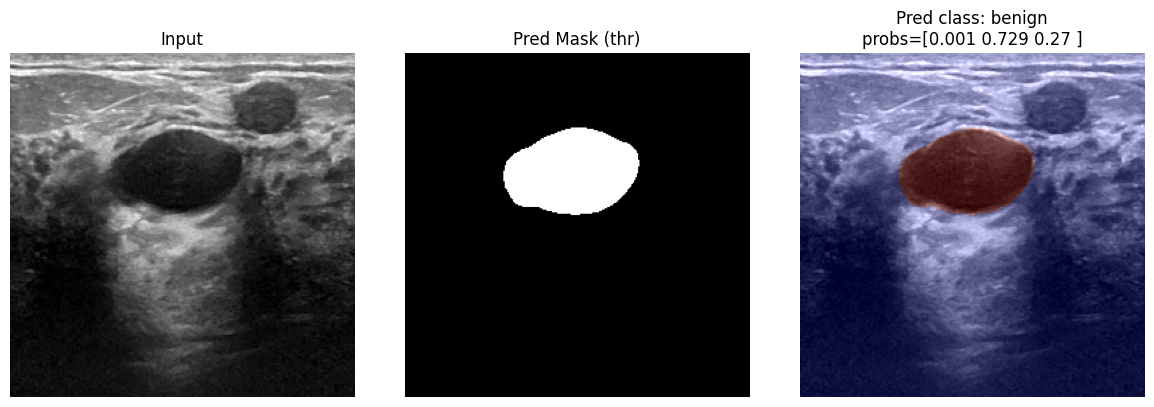

In [ ]:
TEST_IMAGE_PATH = None

if TEST_IMAGE_PATH is None:
    idx = np.random.randint(0, len(X_all))
    temp_path = "_temp_sample.png"
    cv2.imwrite(temp_path, (X_all[idx, ..., 0] * 255).astype(np.uint8))
    TEST_IMAGE_PATH = temp_path
    print("Using temp sample:", TEST_IMAGE_PATH)

unet_best = tf.keras.models.load_model(
    UNET_PATH, custom_objects={"bce_dice_loss": bce_dice_loss, "dice_coef": dice_coef}
)
clf_best = tf.keras.models.load_model(CLF_PATH)

pred_mask, cls_id, probs = predict_mask_and_class(TEST_IMAGE_PATH, unet_best, clf_best)

img = preprocess_single(TEST_IMAGE_PATH, IMG_SIZE)[0, ..., 0]
overlay = overlay_mask(img, pred_mask)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(img, cmap="gray"); plt.title("Input"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(pred_mask > 0.5, cmap="gray"); plt.title("Pred Mask (thr)"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(overlay[..., ::-1]); plt.title(f"Pred class: {LABELS[cls_id]}\nprobs={np.round(probs,3)}"); plt.axis("off")
plt.tight_layout(); plt.show()


## 7) Optional: Tkinter GUI (runs locally)

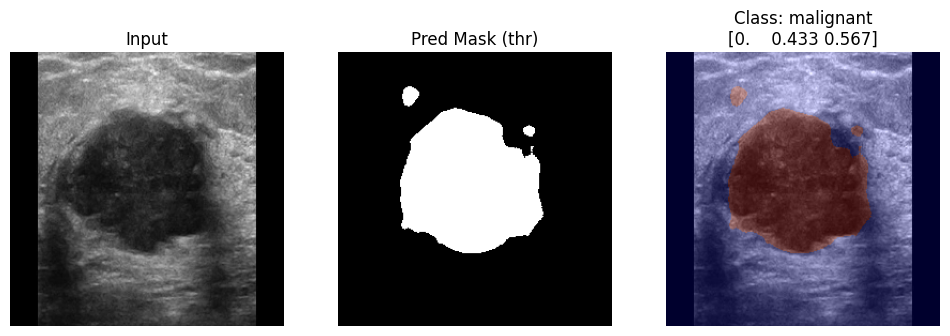

In [ ]:
# NOTE:
# Tkinter GUIs may not run inside some notebook environments.
# This code is meant to be run locally (python script) or in a local Jupyter environment.
import tkinter as tk
from tkinter import filedialog
from PIL import Image

def run_gui(unet_path=UNET_PATH, clf_path=CLF_PATH):
    unet_model = tf.keras.models.load_model(
        unet_path, custom_objects={"bce_dice_loss": bce_dice_loss, "dice_coef": dice_coef}
    )
    clf_model = tf.keras.models.load_model(clf_path)

    def load_image_dialog():
        file_path = filedialog.askopenfilename(title="Select an Image", filetypes=[("PNG Images", "*.png")])
        if not file_path:
            return

        pred_mask, cls_id, probs = predict_mask_and_class(file_path, unet_model, clf_model)

        # Display
        img = preprocess_single(file_path, IMG_SIZE)[0, ..., 0]
        overlay = overlay_mask(img, pred_mask)

        fig, ax = plt.subplots(1, 3, figsize=(12, 4))
        ax[0].imshow(img, cmap="gray"); ax[0].axis("off"); ax[0].set_title("Input")
        ax[1].imshow(pred_mask > 0.5, cmap="gray"); ax[1].axis("off"); ax[1].set_title("Pred Mask (thr)")
        ax[2].imshow(overlay[..., ::-1]); ax[2].axis("off"); ax[2].set_title(f"Class: {LABELS[cls_id]}\n{np.round(probs,3)}")
        plt.show(block=False)

    root = tk.Tk()
    root.title("Breast Ultrasound: Mask + Class")
    root.geometry("420x220")

    tk.Label(root, text="Select an Ultrasound Image (.png)", font=("Arial", 12)).pack(pady=12)
    tk.Button(root, text="Choose Image", command=load_image_dialog, font=("Arial", 12)).pack(pady=10)
    tk.Label(root, text="Outputs: predicted lesion mask + class probabilities", font=("Arial", 10)).pack(pady=10)

    root.mainloop()

# To run locally, uncomment:
# run_gui()
